In [1]:
%load_ext autoreload
%autoreload 2
import os
import sys
import sqlite3


sys.path.insert(0, os.path.abspath('../'))  # add the current module so that we can import the utils file
from tools.utils import get_top_keywords_for_query, create_df_for_query

import numpy as np
import pylab as pl
import matplotlib.pyplot as plt
from matplotlib import collections as mc
import matplotlib.ticker as plticker
from matplotlib.lines import Line2D

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\L\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\L\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


In [2]:
conn = sqlite3.connect('../aip.db')
start_year = 2009  # inclusive
end_year = 2018  # inclusive
num_keywords = 10

In [3]:
def get_cmap(n, name='hsv'):
    '''Returns a function that maps each index in 0, 1, ..., n-1 to a distinct 
    RGB color; the keyword argument name must be a standard mpl colormap name.'''
    return plt.cm.get_cmap(name, n)

In [4]:
def generate_keyword_graph(keyword_ranks_per_year_dict):
    # Get all unique keywords and give them their own array for points.
    keyword_number_dict = dict()
    count = 0
    points = []
    
    for year in range(start_year, end_year + 1):
        for keyword in keyword_ranks_per_year_dict[year]:
            if keyword not in keyword_number_dict:
                points.append([[], []])
                keyword_number_dict[keyword] = count
                count += 1

    num_lines = len(keyword_number_dict.keys())
    print("Number of unique keywords: {}".format(num_lines))
    print(keyword_number_dict)
    
    # Create a color map and generate colors equal to the number of unique keywords we want to track
    cmap = get_cmap(len(keyword_number_dict.keys()))
    c = [cmap(i) for i in range(len(keyword_number_dict.keys()))]
    
    # For each keyword, track it's rank throughout the years
    for keyword, line_array_number in keyword_number_dict.items():
        for year in range(start_year, end_year + 1):
            # The horizontal position is the year, offset by the start_year
            horizontal_position = year - start_year
            
            # The vertical position is the inverse of its rank -- we want #1 to be at the top of the figure
            if keyword in keyword_ranks_per_year_dict[year]:
                vertical_position = abs(keyword_ranks_per_year_dict[year].index(keyword) - num_keywords)
            else:
                vertical_position = 0  # The graph starts at 0, this is the bottom rank.
                            
            # Add a point for the combination of (position (horizontal axis), inversed rank (vertical axis))
            points[keyword_number_dict[keyword]][0].append(horizontal_position)
            points[keyword_number_dict[keyword]][1].append(vertical_position)

    # Create line segments from points, taken from https://matplotlib.org/examples/pylab_examples/multicolored_line.html
    lines = []
    for x, y in points:  # For each pair of coodinate, create a segment. Then add all segments as separate lines 
        transposed_points = np.array([x, y]).T.reshape(-1, 1, 2)
        lines.extend(np.concatenate([transposed_points[:-1], transposed_points[1:]], axis=1))
                          
    line_widths = []
    colors = []
    # Now, we can control the color and thickness of each line separately as each segment is a line
    # Matplotlib doesn't allow a segment within a line to be changed in e.g. thickness :(
    for i in range(num_lines):
        # We know that each "actual trend line" now consists of (end_year - start_year) lines
        line_widths.extend([3] * (end_year - start_year - 1) + [3])  # make the last line thicker
        colors.extend([c[i]] * (end_year - start_year))  # Color all line segments the same that belong to the same keyword
    
    lc = mc.LineCollection(lines, colors=colors, linewidths=line_widths)
                   
    horizontal_labels = [x for x in range(start_year, end_year + 1)]
    vertical_labels =  ["<{}".format(num_keywords)] + [i for i in range(num_keywords, 0, -1)]
    
    #print(horizontal_labels)
    #print(vertical_labels)
    #print(c)
    #print(line_widths)
    
    fig, ax = pl.subplots(figsize=(12,8))
    ax.autoscale()
    ax.set_xlim(-0.2, end_year - start_year + 0.2)  # Add a small amount so that the lines are better visible at the edges
    ax.set_ylim(-0.4, num_keywords + 0.4)  # Add a small amount so that the lines are better visible at the edges
    ax.set_xticks(np.arange(0, end_year - start_year + 1, 1))
    ax.set_yticks(np.arange(0, num_keywords + 1, 1))
    ax.set_xticklabels(horizontal_labels, fontsize=12)
    ax.set_yticklabels(vertical_labels, fontsize=12)
    ax.add_collection(lc)
    
    ax.set_xlabel("Year", fontsize=18)
    ax.set_ylabel("Rank", fontsize=18)
    
    # For visibility, we add markers at the ends of each segment.
    marker_shapes = ['o', 'P', 'D', 'v', '^', '<', '>', 'X', '*', 'p', 'd', 'x', '+', '1', '2', '3', '4',]
    marker_size = 8
    for keyword, array_index in keyword_number_dict.items():
        x = points[array_index][0]
        y = points[array_index][1]
        color = [c[array_index]] * len(x)
        marker = marker_shapes[array_index % len(marker_shapes)]

        ax.scatter(x, y, c=color, marker=marker, s=60)
    
    # code based on https://stackoverflow.com/questions/19877666/add-legends-to-linecollection-plot
    def make_proxy(line_number, color_map, **kwargs):
        color = color_map(line_number)
        return Line2D([0, 1], [0, 1], color=color, **kwargs)
    
    # Add a custom legend
    proxies = [make_proxy(array_index, cmap, linewidth=1, marker= marker_shapes[array_index % len(marker_shapes)], markersize=marker_size) for array_index in keyword_number_dict.values()]
    ax.legend(proxies, keyword_number_dict.keys(), bbox_to_anchor=(1, 1.017), fontsize=13)
    

In [32]:
def generate_keyword_graph_emphasize_most_recent_top_10(keyword_ranks_per_year_dict, add_flat_lines=False):
    # Get all unique keywords and give them their own array for points.
    keyword_number_dict = dict()
    count = 0
    lines = []
    keyword_to_color = dict()
    
    for year in range(start_year, end_year + 1):
        for keyword in keyword_ranks_per_year_dict[year]:
            if keyword not in keyword_number_dict:
                lines.append([])
                keyword_number_dict[keyword] = count
                count += 1

    num_lines = len(keyword_number_dict.keys())
    print("Number of unique keywords: {}".format(num_lines))
    print(keyword_number_dict)
    
    # Create a color map and generate colors equal to the number of unique keywords we want to track
    cmap = get_cmap(len(keyword_number_dict.keys()))
    c = [cmap(i) for i in range(len(keyword_number_dict.keys()))]
    
    # For each keyword, track it's rank throughout the years
    for keyword in keyword_number_dict.keys():
        for year in range(start_year, end_year + 1):
            # The horizontal position is the year, offset by the start_year
            horizontal_position = year - start_year
            
            # The vertical position is the inverse of its rank -- we want #1 to be at the top of the figure
            if keyword in keyword_ranks_per_year_dict[year]:
                vertical_position = abs(keyword_ranks_per_year_dict[year].index(keyword) - num_keywords)
            else:
                vertical_position = 0  # The graph starts at 0, this is the bottom rank.
                            
            # Add a point for the combination of (position (horizontal axis), inversed rank (vertical axis))
            lines[keyword_number_dict[keyword]].append((horizontal_position, vertical_position))
            # Add a fake point halfway through the year where so that we create a flat per point.
            # This is done to add some stability in the graph to improve readability.
            # Do not add this point at the end, though.
            if year != end_year and add_flat_lines:
                lines[keyword_number_dict[keyword]].append((horizontal_position + .5, vertical_position))
        
    line_widths = []
    colors = []
    diffrentiating_colors = [
        "#e41a1c",
        "#377eb8",
        "#4daf4a",
        "#984ea3",
        "#ff7f00",
        "#ffff00",
        "#a65628",
        "#f781bf",
        "#000000",
        "#a6cee3",
        "#999999",
    ]
    # Now, we can control the color and thickness of each line separately as each segment is a line
    # Matplotlib doesn't allow a segment within a line to be changed in e.g. thickness :(
    for keyword in keyword_number_dict.keys():
        rank_in_last_year = keyword_ranks_per_year_dict[end_year].index(keyword) if keyword in keyword_ranks_per_year_dict[end_year] else num_keywords + 1
        if rank_in_last_year >= num_keywords: # >= because the rank is 0-based
            line_widths.append(2)  # Not a top-10 line, so not thick
            colors.append('grey')  # Not a top-10 line, so grey color.
            keyword_to_color[keyword] = 'grey'
        else:
            color = diffrentiating_colors[rank_in_last_year % len(diffrentiating_colors)]
            line_widths.append(13 - rank_in_last_year)  # The most important keyword has the thickest line
            colors.append(color)  # Set the color
            keyword_to_color[keyword] = color
    
    lc = mc.LineCollection(lines, colors=colors, linewidths=line_widths)
                   
    horizontal_labels = [x for x in range(start_year, end_year + 1)]
    vertical_labels =  ["<{}".format(num_keywords)] + [i for i in range(num_keywords, 0, -1)]
    
    #print(horizontal_labels)
    #print(vertical_labels)
    #print(c)
    #print(line_widths)
    
    fig, ax = pl.subplots(figsize=(24,8))
    #ax.autoscale()
    ax.set_xlim(-0.2, end_year - start_year + 0.2)  # Add a small amount so that the lines are better visible at the edges
    ax.set_ylim(-0.4, num_keywords + 0.4)  # Add a small amount so that the lines are better visible at the edges
    ax.set_xticks(np.arange(0, end_year - start_year + 1, 1))
    ax.set_yticks(np.arange(0, num_keywords + 1, 1))
    ax.set_xticklabels(horizontal_labels, fontsize=32)
    ax.set_yticklabels(vertical_labels, fontsize=32)
    ax.add_collection(lc)
    
    ax.set_xlabel("Year", fontsize=40)
    ax.set_ylabel("Rank", fontsize=40)
    
    def sort_func(x):
        return keyword_ranks_per_year_dict[end_year].index(x[0]) if x[0] in keyword_ranks_per_year_dict[end_year] else num_keywords + 1
    sorted_items_for_markers = sorted(keyword_number_dict.items(), key=sort_func)
    
    # For visibility, we add markers at the ends of each segment.
    marker_shapes = ['o', 'P', 'D', 'v', '^', '<', '>', 'X', '*', 'p', 'd', 'x', '+', '1', '2', '3', '4',]
    marker_size = 8
    for index, (keyword, array_index) in enumerate(sorted_items_for_markers):
        x = [x[0] for x in lines[array_index]]
        y = [x[1] for x in lines[array_index]]
        color = [keyword_to_color[keyword]] * len(x)
        marker = marker_shapes[index % len(marker_shapes)]

        ax.scatter(x, y, c=color, marker=marker, s=60)
    
    # code based on https://stackoverflow.com/questions/19877666/add-legends-to-linecollection-plot
    def make_proxy(color, **kwargs):
        return Line2D([0, 1], [0, 1], color=color, **kwargs)
    
    # Add a custom legend
    proxies = [make_proxy(keyword_to_color[keyword], linewidth=1, marker= marker_shapes[index % len(marker_shapes)], markersize=marker_size) for index, (keyword, _) in enumerate(sorted_items_for_markers)]
    legend = ax.legend(proxies, [x[0] for x in sorted_items_for_markers], ncol=2, bbox_to_anchor=(1, 1.017), fontsize=28, bbox_transform=ax.transAxes, markerscale=2)

In [7]:
# Construct the corpus dataframe that we want to run TF-IDF against
corpus_query = """
    SELECT * 
    FROM publications 
    WHERE year BETWEEN ? AND ?"""
corpus_df = create_df_for_query(conn, corpus_query, [start_year, end_year])

# generate_keyword_graph(keywords_per_year)
#generate_keyword_graph_emphasize_most_recent_top_10(keywords_per_year)

In [8]:
queries = [
# Workflow communities - 1
(
    """
    SELECT *
    FROM publications 
    WHERE year = ?
    AND (lower(title) LIKE '%workflow%' OR lower(abstract) LIKE '%workflow%') 
    AND (lower(title) LIKE '%schedul%' OR lower(abstract) LIKE '%schedul%')
    """,
    "workflow-community",
    "collaboration-network-workflow-scheduling_aip.gexf"
),

# Workflow formalisms - 2
# (
#     """
#     SELECT *
#     FROM publications 
#     WHERE year = ?
#     AND (lower(title) LIKE '%workflow%' OR lower(abstract) LIKE '%workflow%') 
#     AND (
#         (lower(title) LIKE '%formalism%' OR lower(abstract) LIKE '%formalism%') 
#         OR (lower(title) LIKE '%language%' OR lower(abstract) LIKE '%language%')
#     )
#     """,
#     "workflow-formalism-community",
#     "collaboration-network-workflow-formalisms_aip.gexf"
# ),
    
# # Workflow allocation - 3
# (
#     """
#     SELECT *
#     FROM publications 
#     WHERE (lower(title) LIKE '%workflow%' OR lower(abstract) LIKE '%workflow%') 
#     AND (
#         (lower(title) LIKE '%allocat%' OR lower(abstract) LIKE '%allocat%') 
#         OR (lower(title) LIKE '%schedul%' OR lower(abstract) LIKE '%schedul%') 
#         OR (lower(title) LIKE '%plan%' OR lower(abstract) LIKE '%plan%')
#     ) 
#     AND year = ?
#     """,
#     "workflow-allocation-community",
#     "collaboration-network-workflow-allocation_aip.gexf"
# ),

    
# # Resource provisioning communities - 4
# (
#     """
#     SELECT *
#     FROM publications 
#     WHERE year = ?
#     AND (lower(title) LIKE '%workflow%' OR lower(abstract) LIKE '%workflow%') 
#     AND (
#         lower(title) LIKE '%provision%' OR lower(abstract) LIKE '%provision%' 
#         OR lower(title) LIKE '%autoscal%' OR lower(abstract) LIKE '%autoscal%'
#     )
#     """,
#     "resource-provisioning-community",
#     "collaboration-network-resource-provisioning_aip.gexf"
# ),

# # applications and services - 5
# (
#     """
#     SELECT *
#     FROM publications 
#     WHERE year = ?
#     AND (lower(title) LIKE '%cloud%' OR lower(abstract) LIKE '%cloud%') 
#     AND (lower(title) LIKE '%service%' OR lower(abstract) LIKE '%service%')
#     """,
#     "applications-and-services-community",
#     "collaboration-network-applications-and-services-community_aip.gexf"
# ),
]

In [9]:
keywords_per_year = dict()
custom_stopwords_for_query = set(["resource", "execution", "scientific", "service", "management", "based", 
                              "computing", "schedule", "approach", "different", "distributed", "science", 
                              "system", "intensive", "aware", "executing", "science", "file", "characteristic", 
                              "complex", "bi", "proposed", "transfer", "hybrid", "directed", "constraint", 
                              "constrained", "multi", "multiple", "scientist", "tolerance"])

for year in range(start_year, end_year + 1):
    query = """
    SELECT * 
    FROM publications 
    WHERE year = ? 
    AND (title like '%workflow%' or abstract like '%workflow%') 
    AND (title like '%schedul%' or abstract like '%schedul%')"""
    keywords = [x for x in get_top_keywords_for_query(conn, corpus_df, query, 50, [year]) if x not in custom_stopwords_for_query]
    keywords_per_year[year] = keywords[:num_keywords]

Number of unique keywords: 22
{'workflow': 0, 'scheduling': 1, 'grid': 2, 'application': 3, 'algorithm': 4, 'time': 5, 'environment': 6, 'job': 7, 'task': 8, 'cloud': 9, 'data': 10, 'performance': 11, 'user': 12, 'provisioning': 13, 'cost': 14, 'two': 15, 'optimization': 16, 'objective': 17, 'makespan': 18, 'deadline': 19, 'scheduler': 20, 'heuristic': 21}
Number of unique keywords: 22
{'workflow': 0, 'scheduling': 1, 'grid': 2, 'application': 3, 'algorithm': 4, 'time': 5, 'environment': 6, 'job': 7, 'task': 8, 'cloud': 9, 'data': 10, 'performance': 11, 'user': 12, 'provisioning': 13, 'cost': 14, 'two': 15, 'optimization': 16, 'objective': 17, 'makespan': 18, 'deadline': 19, 'scheduler': 20, 'heuristic': 21}
Number of unique keywords: 22
{'workflow': 0, 'scheduling': 1, 'grid': 2, 'application': 3, 'algorithm': 4, 'time': 5, 'environment': 6, 'job': 7, 'task': 8, 'cloud': 9, 'data': 10, 'performance': 11, 'user': 12, 'provisioning': 13, 'cost': 14, 'two': 15, 'optimization': 16, 'objec

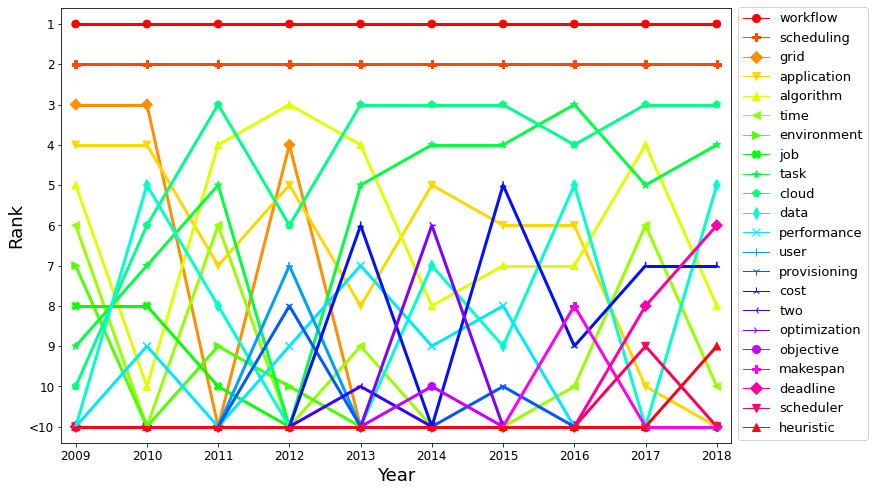

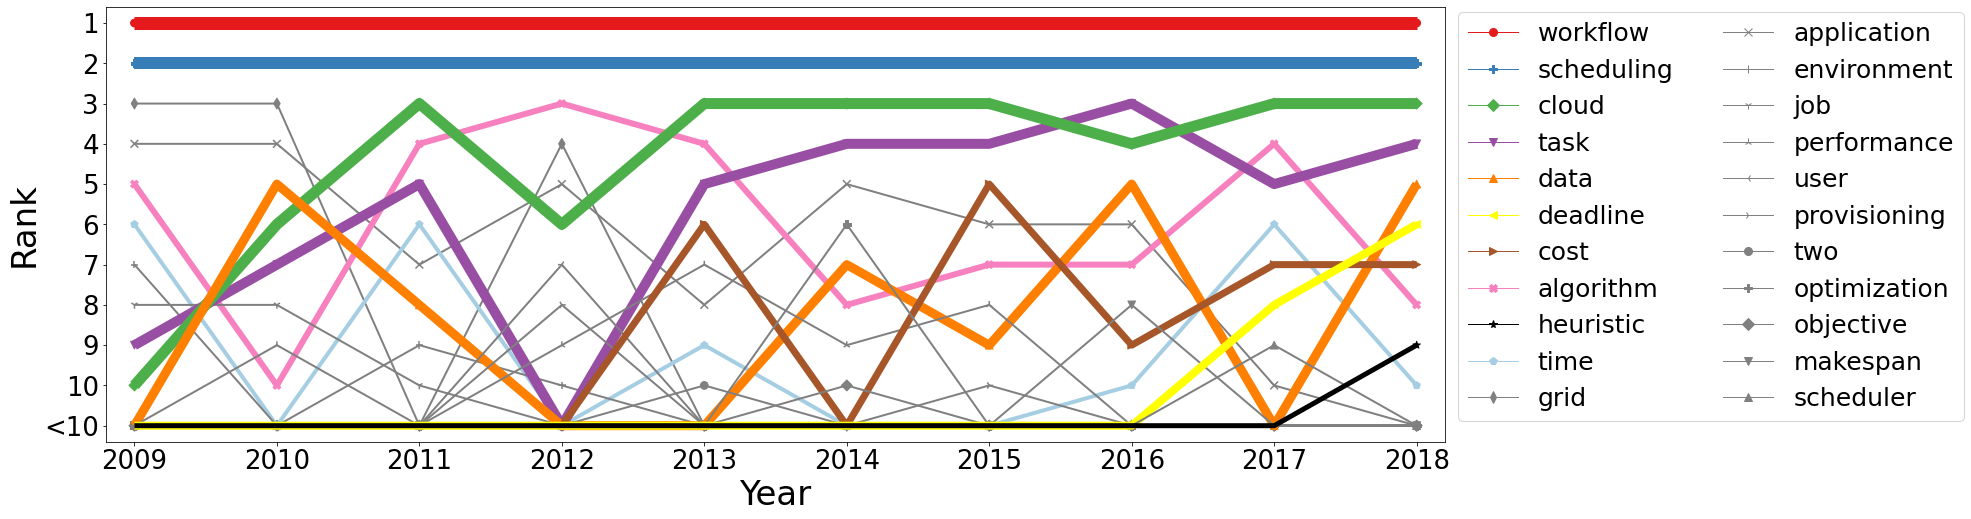

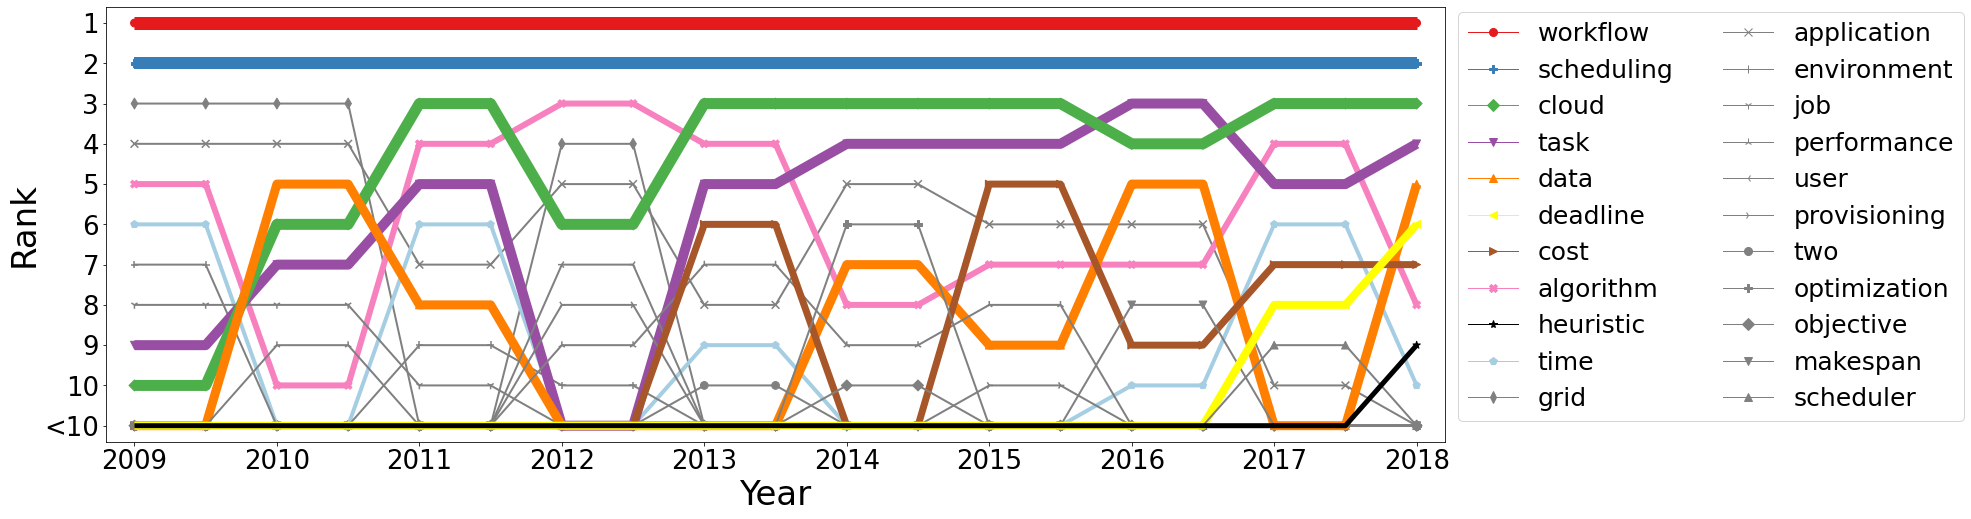

In [10]:
generate_keyword_graph(keywords_per_year)

generate_keyword_graph_emphasize_most_recent_top_10(keywords_per_year)
generate_keyword_graph_emphasize_most_recent_top_10(keywords_per_year, True)

workflow-community
Number of unique keywords: 21
{'workflow': 0, 'scheduling': 1, 'grid': 2, 'application': 3, 'algorithm': 4, 'time': 5, 'environment': 6, 'job': 7, 'task': 8, 'cloud': 9, 'data': 10, 'performance': 11, 'user': 12, 'provisioning': 13, 'cost': 14, 'deadline': 15, 'optimization': 16, 'objective': 17, 'makespan': 18, 'scheduler': 19, 'heuristic': 20}


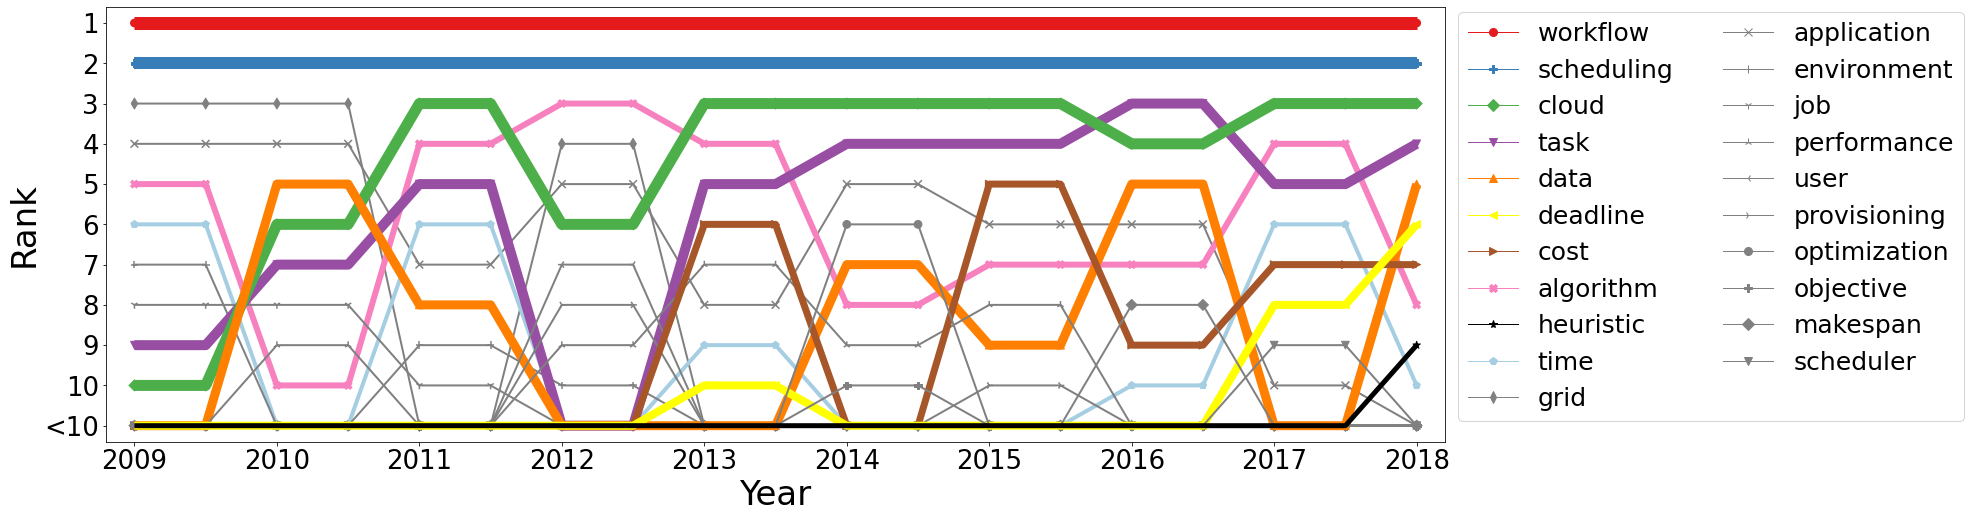

In [11]:
custom_stopwords_for_query = set(["resource", "execution", "scientific", "service", "management", "based", 
                              "computing", "schedule", "approach", "different", "distributed", "science", 
                              "system", "intensive", "aware", "executing", "science", "file", "characteristic", 
                              "complex", "bi", "proposed", "transfer", "hybrid", "directed", "constraint", 
                              "constrained", "multi", "multiple", "scientist", "tolerance", "overall", "driven",
                                 "improve", "make", "continue", "popularity", "extended", "problem", "predefined",
                                 "using", "ideal", "extension", "composition", "abstraction", "level", "processing",
                                 "activity", "structured", "use", "changing", "easy", "achieved", "permit",
                                 "involved", "remote", "oriented", "managing", "crucial", "describes", "modeled",
                                 "executed", "expressed", "finding", "existing", "program", "discus", "underlying",
                                 "increasingly", "exploration", "large", "suggest", "describe", "process", "work",
                                 "complexity", "authored", "facing", "two", "taken", "posit", "usage", "strategy", 
                                  "various", "result", "complicated", "turning", "knowledge", "achieve", "set", 
                                  "review", "diverse", "available", "bed", "drawn", "collaborative", "charm", 
                                  "definition", "technique", "would", "submission", "effective", "juju", 
                                  "specific", "used", "followed", "hive"])

for query, community_name, _ in queries:
    print(community_name)
    keywords_per_year = dict()
    for year in range(start_year, end_year + 1):
        keywords = [x for x in get_top_keywords_for_query(conn, corpus_df, query, 50, [year]) if x not in custom_stopwords_for_query]
        keywords_per_year[year] = keywords[:num_keywords]
    generate_keyword_graph_emphasize_most_recent_top_10(keywords_per_year, True)

Number of unique keywords: 21
{'workflow': 0, 'scheduling': 1, 'grid': 2, 'application': 3, 'algorithm': 4, 'time': 5, 'environment': 6, 'job': 7, 'task': 8, 'cloud': 9, 'data': 10, 'performance': 11, 'user': 12, 'provisioning': 13, 'cost': 14, 'deadline': 15, 'optimization': 16, 'objective': 17, 'makespan': 18, 'scheduler': 19, 'heuristic': 20}


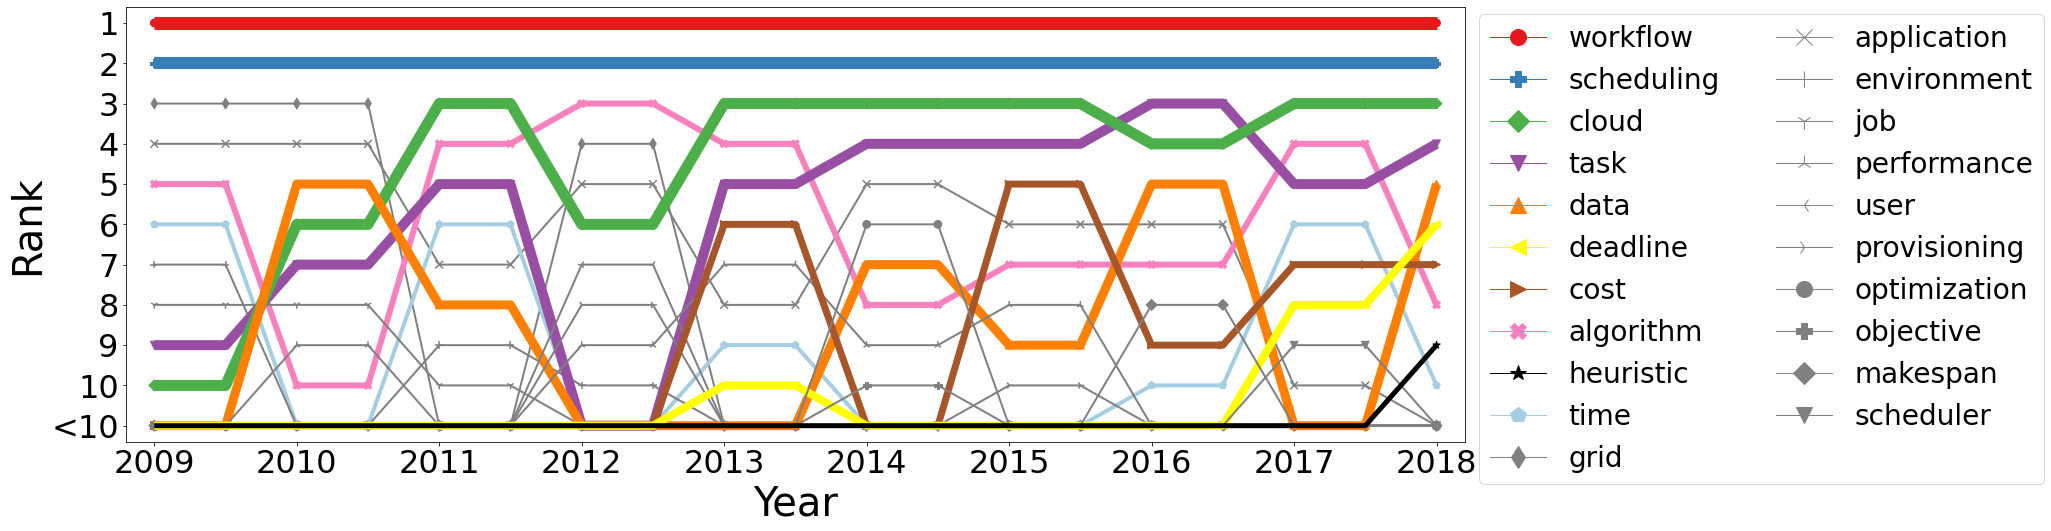

In [33]:
generate_keyword_graph_emphasize_most_recent_top_10(keywords_per_year, True)